# Asylum Applications and Schengen Visa Rejection Rates: Exploring the Connection

In this post, I'll be discussing the intriguing relationship between the number of asylum applications and Schengen visa rejection rates. In the past decades, political unrest, humanitarian crises, or sheer poverty have forced many people to seek refuge in Schengen countries. This made me wonder if the increase in asylum applications could be affecting the Schengen visa rejection rates for applicants from these troubled countries. 

My question is: Is there a correlation between the increasing number of asylum applications from a country's citizens and the subsequent rise in rejection rates for Schengen visa applications from that country's residents?

## Creating the DataFrame
The data of each year is stored in different excel sheets, and a third of them are not formatted the same. However, this is easily solvable with Python.

I stored the similarly-formatted excel files in the same folder and loaded them onto Pandas. After merging them together, I used "re.findall()" to assign the proper year based on the file name which includes the year.

| app_country      | Country where the applications was made |
|------------------|-----------------------------------------|
| schengen_state   | Schengen state that applicant applied to|
| consulate        | Schengen state consulate               |
| app              | Number of Schengen visa applications    |
| rejected         | Number of Schengen visa rejections      |
| asyl_app         | Asylum applications made by nationals of the "application country" in "Schengen" states |


In [90]:
import pandas as pd
import glob
import os
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import re
import pycountry
import country_converter as coco
from scipy import stats
from scipy.stats import spearmanr
import statsmodels.api as sm

In [2]:
df = pd.DataFrame()
for f in glob.glob('.../*.xlsx'):
    data = pd.read_excel(f, sheet_name='Data for consulates')
    data['year'] = int(re.findall(r'.*([1-3][0-9]{3})', f)[0])
    df = df.append(data,ignore_index=True)

In [3]:
df = df.iloc[:, [0,1,2,8,9,10,12,13,-1]]

In [4]:
column_names = ["schengen_state", "app_country", "consulate", "app","total_issued", "mev_issued", 
                "ltv", "rejected", 'year']
df.columns = column_names

I need to reformat the ones that are formatted properly, starting with 2013. I add the year column manually. To standardise the column names, I check that the columns of the first dataframe and the 2013 dataframe are aligned and assign the new dataframe the names from the original column

In [5]:
df2013 = pd.read_excel(".../synthese_2013_with_filters_en.xls", sheet_name='Complete data')

In [6]:
df2013['year'] = 2013
df2013 = df2013.iloc[:, [0,1,2,8,9,10,12,13,-1]]
df2013.columns = df.columns

Reading the 2012 file:

In [7]:
df2012 = pd.read_excel(".../synthese_2012_with_filters_en.xlsx", sheet_name='Sheet1')

In [8]:
df2012.head()

,Schengen State,World region,Country where consulate is located,Location of consulate,A visas issued,Multiple A visas issued,A Visas applied for,A visas not issued,C visas issued (including MEV) \n,Multiple entry C visas issued,Share of MEVs on issued C visas,C visas applied for,C visas not issued,Total A and C visas issued (including multiple-entry A visas and multiple-entry C visas),Total A and C visas applied for.,Total A and C visas not issued,Not issued rate for A and C visas,Total LTV visas issued,"Total A, C and LTV visas issued",Rate LTV visas issued / C visas issued
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DENMARK,SOUTH&EAST ASIA,AFGHANISTAN,KABUL,NaN,NaN,NaN,NaN,59,5,0.084746,74,7,59,74,7,0.094595,9,68,0.152542
2,France,SOUTH&EAST ASIA,AFGHANISTAN,KABUL,4,NaN,4,NaN,1143,141,0.12336,1189,46,1147,1193,46,0.038558,547,1694,0.478565
3,GERMANY,SOUTH&EAST ASIA,AFGHANISTAN,KABUL,NaN,NaN,NaN,NaN,1571,22,0.014004,2892,1321,1571,2892,1321,0.456777,52,1623,0.0331
4,ITALY,SOUTH&EAST ASIA,AFGHANISTAN,KABUL,0,0,0,0,417,324,0.776978,471,54,417,471,54,0.11465,243,660,0.582734


Choosing the necessary columns and renaming them with the column names of the main dataframe:

In [9]:
df2012 = df2012.iloc[:, [0,2,3,11,8,9,12]]

In [10]:
column_names2 = ["schengen_state", "app_country", "consulate", "app","total_issued", "mev_issued", "rejected"]
df2012.columns = column_names2
df2012['year'] = 2012

In [11]:
df2011 = pd.read_excel(".../synthese_2011_with_filters_en.xls", sheet_name='SCHENGEN')

In [12]:
df2011 = df2011.iloc[:, [0,2,3,11,8,9,12]]
column_names2 = ["schengen_state", "app_country", "consulate", "app","total_issued", "mev_issued", "rejected"]
df2011.columns = column_names2
df2011['year'] = 2011

In [13]:
df2010 = pd.read_excel(".../synthese_2010_with_filters_en.xls", sheet_name='SCHENGEN')

In [14]:
df2010 = df2010.iloc[:, [2,0,1,9,6,7]]
column_names2 = ["schengen_state", "app_country", "consulate", "app","total_issued", "mev_issued"]
df2010.columns = column_names2
df2010['rejected'] = df2010['app'] - df2010['total_issued']
df2010['year'] = 2010
df2010['schengen_state'].replace('EL', 'GR', inplace=True)

In [15]:
input_code = df2010['schengen_state']

countries = {}
for country in pycountry.countries:
    countries[country.alpha_2] = country.name

df2010['schengen_state'] = [countries.get(country, 'Unknown code') for country in input_code]
print(df2010['schengen_state'].unique())

['Austria' 'Belgium' 'Switzerland' 'Czechia' 'Germany' 'Denmark' 'Estonia'
 'Spain' 'Greece' 'Finland' 'France' 'Hungary' 'Iceland' 'Italy'
 'Lithuania' 'Luxembourg' 'Latvia' 'Malta' 'Netherlands' 'Norway' 'Poland'
 'Portugal' 'Sweden' 'Slovenia' 'Slovakia' 'Unknown code']


In [16]:
df2009 = pd.read_excel(".../statistiques2009.xls", sheet_name='Visa Statistics 2009')

In [17]:
df2009 = df2009.iloc[:, [3,1,2,7,6, 11]]
column_names3 = ["schengen_state", "app_country", "consulate", "app","total_issued", "rejected"]
df2009.columns = column_names3
df2009['year'] = 2009

After I am done with this process, I put the "delinquent" data frames in a list and merged with the main data frame:

In [18]:
df_list = [df2013, df2012, df2011, df2010, df2009]

In [19]:
for g in df_list:
    df = df.append(g,ignore_index=True)

In [20]:
df['year'].unique()

array([2021, 2017, 2018, 2019, 2016, 2015, 2014, 2020, 2013, 2012, 2011,
       2010, 2009])

### Cleaning the DataFrame

The excel files included some explanatory notes that do not belong in the daraframe. Since they start from the third column, it was easy to remove with drop.na():

In [21]:
df = df.dropna(subset=['schengen_state', 'app_country'])
df = df.fillna(0)

Checking amount of na values:

In [22]:
for col in df.columns:
    pct_missing = (np.mean(df[col].isnull())*100)
    print('{} - {}%'.format(col, pct_missing))

schengen_state - 0.0%
app_country - 0.0%
consulate - 0.0%
app - 0.0%
total_issued - 0.0%
mev_issued - 0.0%
ltv - 0.0%
rejected - 0.0%
year - 0.0%


Checking column types:

In [23]:
df.dtypes

schengen_state     object
app_country        object
consulate          object
app               float64
total_issued      float64
mev_issued        float64
ltv               float64
rejected           object
year                int64
dtype: object

The "rejected" (number of rejections)column is stored as an object, so I should turn it into a numeric one:

In [24]:
df['rejected'] = df['rejected'].apply(pd.to_numeric, errors='coerce').astype('float64')

Just making sure that there are no empty spaces:

In [25]:
df['app_country']=df['app_country'].str.strip()
df['consulate']=df['consulate'].str.strip()
df['schengen_state'] = df['schengen_state'].str.strip()

Checking if there is a case mismatch:

In [26]:
df['schengen_state'].unique()

array(['Austria', 'Belgium', 'Czech Republic', 'Denmark', 'Estonia',
       'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland',
       'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta',
       'Netherlands', 'Norway', 'Poland', 'Portugal', 'Slovakia',
       'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'DENMARK', 'GERMANY',
       'ITALY', 'NETHERLANDS', 'NORWAY', 'POLAND', 'SPAIN', 'AUSTRIA',
       'CZECH REPUBLIC', 'GREECE', 'HUNGARY', 'SLOVENIA', 'BELGIUM',
       'FINLAND', 'SWEDEN', 'SWITZERLAND', 'LITHUANIA', 'SLOVAKIA',
       'ESTONIA', 'MALTA', 'LATVIA', 'ICELAND', 'FRANCE', 'CZECH REP.',
       'Czechia', 'BULGARIA', 'ROMANIA', 'PORTUGAL', 'CYPRUS',
       'LUXEMBOURG'], dtype=object)

There is a case mismatch. I'll fix that:

In [27]:
df['schengen_state'] = df['schengen_state'].str.title()

In [28]:
df['schengen_state'].unique()

array(['Austria', 'Belgium', 'Czech Republic', 'Denmark', 'Estonia',
       'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland',
       'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta',
       'Netherlands', 'Norway', 'Poland', 'Portugal', 'Slovakia',
       'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Czech Rep.',
       'Czechia', 'Bulgaria', 'Romania', 'Cyprus'], dtype=object)

Czechia has many names let's change that:

In [29]:
df['schengen_state'] = df['schengen_state'].replace(['Czech Rep.', "Czech Republic"], 
                                                    ['Czechia' ,'Czechia'])

Also older datasets also included non-schengen countries: Bulgaria, Romania, Cyprus. Let's remove them

In [30]:
df = df[df['schengen_state'].str.contains("Bulgaria|Romania|Cyprus")==False]

In [31]:
len(df['schengen_state'].unique())

25

There are 25 schengen states excluding Liechtenstein, which is not in this dataframe. 

In [32]:
df['app_country'].unique()

array(['ALBANIA', 'ALGERIA', 'ARGENTINA', 'AUSTRALIA', 'AZERBAIJAN',
       'BOSNIA AND HERZEGOVINA', 'BRAZIL', 'BULGARIA', 'CANADA', 'CHILE',
       'CHINA', 'COLOMBIA', 'CROATIA', 'CUBA', 'CYPRUS', 'EGYPT',
       'ETHIOPIA', 'GERMANY', 'HONG KONG S.A.R.', 'INDIA', 'INDONESIA',
       'IRAN', 'IRELAND', 'ISRAEL', 'JAPAN', 'JORDAN', 'KAZAKHSTAN',
       'KENYA', 'KUWAIT', 'LEBANON', 'MALAYSIA', 'MEXICO', 'MOROCCO',
       'NIGERIA', 'NORTH MACEDONIA', 'OMAN', 'PAKISTAN', 'PERU',
       'PHILIPPINES', 'ROMANIA', 'RUSSIAN FEDERATION', 'SAUDI ARABIA',
       'SENEGAL', 'SERBIA', 'SLOVAKIA', 'SLOVENIA', 'SOUTH AFRICA',
       'SOUTH KOREA', 'SYRIA', 'TAIWAN', 'THAILAND', 'TUNISIA', 'TURKEY',
       'UKRAINE', 'UNITED ARAB EMIRATES', 'UNITED KINGDOM', 'USA',
       'VIETNAM', 'ANGOLA', 'BELGIUM', 'BURKINA FASO', 'BURUNDI',
       'CAMEROON', 'CONGO (DEMOCRATIC REPUBLIC)', "COTE D'IVOIRE",
       'FRANCE', 'GREECE', 'HUNGARY', 'ITALY', 'JAMAICA', 'NETHERLANDS',
       'PANAMA', 'POLAND', 'P

I want to standardise the name of the countries of the laterIn this column all countries are in upper case. I want them in lower case but capitalised except the stop words. 

First, I converted all of the text in that column to lowercase using the str.lower() method.Next, I defined a function called title_except that capitalized the first letter of each word in a sentence or phrase, but with some exceptions. For example, if the words "and" or "of" were in the sentence, I wanted to keep them lowercase.After that, I created a list of exceptions containing the words I wanted to keep lowercase. In this case, the words were "and" and "of". Finally, I applied the title_except function to each value in the app_country column using the apply() method. I used a lambda function to pass the title_except function with the list of exceptions as the second argument. This way, I ensured that the first letter of each word in the app_country column was capitalized, except for the words "and" and "of":use:

In [33]:
df['app_country'] = df['app_country'].str.lower()
def title_except(s, exceptions):
    word_list = re.split(' ', s)    
    final = [word_list[0].capitalize()]
    for word in word_list[1:]:
        final.append(word if word in exceptions else word.capitalize())
    return " ".join(final)

articles = ['and', 'of']
df['app_country'] = df['app_country'].apply(lambda x: title_except(x, articles))

In [34]:
df['app_country'].unique()

array(['Albania', 'Algeria', 'Argentina', 'Australia', 'Azerbaijan',
       'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Canada', 'Chile',
       'China', 'Colombia', 'Croatia', 'Cuba', 'Cyprus', 'Egypt',
       'Ethiopia', 'Germany', 'Hong Kong S.a.r.', 'India', 'Indonesia',
       'Iran', 'Ireland', 'Israel', 'Japan', 'Jordan', 'Kazakhstan',
       'Kenya', 'Kuwait', 'Lebanon', 'Malaysia', 'Mexico', 'Morocco',
       'Nigeria', 'North Macedonia', 'Oman', 'Pakistan', 'Peru',
       'Philippines', 'Romania', 'Russian Federation', 'Saudi Arabia',
       'Senegal', 'Serbia', 'Slovakia', 'Slovenia', 'South Africa',
       'South Korea', 'Syria', 'Taiwan', 'Thailand', 'Tunisia', 'Turkey',
       'Ukraine', 'United Arab Emirates', 'United Kingdom', 'Usa',
       'Vietnam', 'Angola', 'Belgium', 'Burkina Faso', 'Burundi',
       'Cameroon', 'Congo (democratic Republic)', "Cote D'ivoire",
       'France', 'Greece', 'Hungary', 'Italy', 'Jamaica', 'Netherlands',
       'Panama', 'Poland', 'P

In different files, same countries have different names. I cannot automatically standardise them because countries like Congos and Koreas share very similar names. Instead I'll do it manually:

In [35]:
country_map = {'Iran, Islamic Republic of': 'Iran',
               'Congo, The Democratic Republic of The': 'Congo DR',
               'Congo (democratic Republic)': 'Congo DR',
               'Congo': 'Congo-Brazzaville',
               'Congo (brazzaville)': 'Congo-Brazzaville',
               'Moldova, Republic of': 'Moldova',
               'Libyan Arab Jamahiriya': 'Libya',
               'Taiwan, Province of China': 'Taiwan',
               'Macao S.a.r.': 'Macao',
               'Holy See (vatican City State)': 'Holy See',
               'Palestinian Authority': 'Palestine',
               'Former Yugoslav Republic of Macedonia': 'North Macedonia',
               "Macedonia, The Former Yugoslav Republic of": "North Macedonia",
               "Korea, Democratic People's Republic of": 'North Korea',
               'Korea, Republic of': 'South Korea',
               "Lao People's Democratic Republic": 'Laos',
               "Hong Kong S.a.r.": 'Hong Kong',
               'Tanzania, United Republic of': 'Tanzania',
               'Usa': 'United States',
               'Guinea-bissau': 'Guinea-Bissau',
               "Palestine (occupied Territory Of)": "Palestine",
                "Brunei Darussalam": "Brunei",
                  "Syrian Arab Republic": 'Syria',
              "Russian Federation": 'Russia',
              "Cote D\'ivoire" :"Cote D'ivoire"}

df['app_country'] = df['app_country'].replace(country_map)

In [36]:
df['app_country'].unique()

array(['Albania', 'Algeria', 'Argentina', 'Australia', 'Azerbaijan',
       'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Canada', 'Chile',
       'China', 'Colombia', 'Croatia', 'Cuba', 'Cyprus', 'Egypt',
       'Ethiopia', 'Germany', 'Hong Kong', 'India', 'Indonesia', 'Iran',
       'Ireland', 'Israel', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya',
       'Kuwait', 'Lebanon', 'Malaysia', 'Mexico', 'Morocco', 'Nigeria',
       'North Macedonia', 'Oman', 'Pakistan', 'Peru', 'Philippines',
       'Romania', 'Russia', 'Saudi Arabia', 'Senegal', 'Serbia',
       'Slovakia', 'Slovenia', 'South Africa', 'South Korea', 'Syria',
       'Taiwan', 'Thailand', 'Tunisia', 'Turkey', 'Ukraine',
       'United Arab Emirates', 'United Kingdom', 'United States',
       'Vietnam', 'Angola', 'Belgium', 'Burkina Faso', 'Burundi',
       'Cameroon', 'Congo DR', "Cote D'ivoire", 'France', 'Greece',
       'Hungary', 'Italy', 'Jamaica', 'Netherlands', 'Panama', 'Poland',
       'Portugal', 'Qatar', 'Rwanda',

Liberia and Papua New Guinea has very low applications so I'll remove them

In [37]:
df = df[~df['app_country'].isin(['Liberia', 'Papua New Guinea'])]

The "consulate" column is not necessary, so I'll drop it without losing any relevant data:

In [38]:
df = df.groupby(['app_country','schengen_state', 'year']).sum().reset_index()

I want to merg this dataset with other dataset for analysis. To make that easier, I assign alpha-2 codes to both Schengen states and application countries:

In [39]:
input_countries = df['schengen_state']

countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_2

codes = [countries.get(country, 'Unknown code') for country in input_countries]

In [40]:
df['code_schengen'] = codes
df['code_schengen'].unique()

array(['CZ', 'DK', 'FR', 'DE', 'IT', 'NL', 'NO', 'PL', 'ES', 'SE', 'AT',
       'BE', 'GR', 'HU', 'SI', 'CH', 'FI', 'MT', 'PT', 'LT', 'SK', 'EE',
       'LV', 'LU', 'IS'], dtype=object)

In [41]:
input_countries = df['app_country']

countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_2

df['code_app'] = [countries.get(country, np.nan) for country in input_countries]

In [42]:
df[df['code_app'].isna()]['app_country'].unique()

array(['Bolivia', 'Brunei', 'Cape Verde', 'Congo DR', 'Congo-Brazzaville',
       "Cote D'ivoire", 'Czech Republic', 'Holy See', 'Iran', 'Kosovo',
       'Laos', 'Moldova', 'North Korea', 'Palestine', 'Russia',
       'South Korea', 'Syria', 'Taiwan', 'Tanzania', 'Timor-leste',
       'Venezuela', 'Vietnam'], dtype=object)

Pycountry could not match the alpha-2 codes of some countries. I should remove Vatican and add alpha-2 codes manually:

In [43]:
df.drop(df[df['app_country']=='Holy See'].index, inplace=True)

In [44]:
app_missing = {'Bolivia': 'BO',
        'Brunei': 'BN',
        'Cape Verde': 'CV',
        'Congo DR': 'CD',
        'Congo-Brazzaville': 'CG',
        "Cote D'ivoire": 'CI',
        'Czech Republic': 'CZ',
        'Iran': 'IR',
        'Kosovo': 'XK',
        'Laos': 'LA',
        'Moldova': 'MD',
        'North Korea': 'KP',
        'Palestine': 'PS',
        'South Korea': 'KR',
        'Syria': 'SY',
        'Taiwan': 'TW',
        'Tanzania': 'TZ',
        'Timor-leste': 'TL',
        'Venezuela': 'VE',
        'Vietnam': 'VN',
        "Russia": "RU"}

codes_df = pd.DataFrame(list(app_missing.items()), columns=['app_country', 'code'])

In [45]:
merged_df = df.merge(codes_df, on='app_country', how='left')

merged_df.loc[merged_df['code_app'].isna(), 'code_app'] = merged_df['code']

df = merged_df.drop('code', axis=1)

It is important to know citizens of which countries have visa-free access to the Schengen area. For that I'll create a dataframe and merge it with the main dataframe:

In [46]:
for col in df.columns:
    pct_missing = (np.mean(df[col].isnull())*100)
    print('{} - {}%'.format(col, pct_missing))

app_country - 0.0%
schengen_state - 0.0%
year - 0.0%
app - 0.0%
total_issued - 0.0%
mev_issued - 0.0%
ltv - 0.0%
rejected - 0.0%
code_schengen - 0.0%
code_app - 0.0%


### Merging with Schengen Visa Requirement Information

In [47]:
vfree = pd.read_csv(".../visa_free2.csv", delimiter=';')
vfree['app_country']=vfree['app_country'].str.strip()

In [48]:
input_countries = vfree['app_country']

countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_2

vfree['code_app'] = [countries.get(country, 'Unknown code') for country in input_countries]


In [49]:
vfree[vfree['code_app']=='Unknown code'].drop(['visa_free'], axis=1)

,app_country,code_app
9,Brunei,Unknown code
19,Holy See,Unknown code
30,Micronesia,Unknown code
31,Moldova,Unknown code
44,Saint Vincent,Unknown code
50,South Korea,Unknown code
51,Taiwan,Unknown code
52,Timor Leste,Unknown code
62,Venezuela,Unknown code
65,Czech Republic,Unknown code


In [50]:
countries_dict = {
    'Brunei': 'BN',
    'Holy See': 'VA',
    'Micronesia': 'FM',
    'Moldova': 'MD',
    'Saint Vincent': 'VC',
    'South Korea': 'KR',
    'Taiwan': 'TW',
    'Timor Leste': 'TL',
    'Venezuela': 'VE',
    'Czech Republic': 'CZ'
}
vfree['code_app'] = vfree['code_app'].replace(countries_dict)

In [51]:
vfree = vfree.drop('app_country', axis=1)

In [52]:
vfree['code_app'].unique()

array(['AL', 'AD', 'AG', 'AR', 'AU', 'BS', 'BB', 'BA', 'BR',
       'Unknown code', 'CA', 'CL', 'CO', 'CR', 'DM', 'SV', 'GE', 'GD',
       'GT', 'HN', 'HK', 'IL', 'JP', 'KI', 'MO', 'MY', 'MH', 'MU', 'MX',
       'MC', 'ME', 'NR', 'NZ', 'NI', 'MK', 'PW', 'PA', 'PY', 'PE', 'KN',
       'LC', 'WS', 'RS', 'SC', 'SG', 'SB', 'TO', 'TT', 'TV', 'UA', 'AE',
       'GB', 'US', 'UY', 'VU', 'AT', 'BE', 'DK', 'EE', 'FI', 'FR', 'DE',
       'HU', 'IS', 'IT', 'LV', 'LI', 'LT', 'LU', 'MT', 'NO', 'PL', 'PT',
       'SK', 'SI', 'ES', 'SE', 'CH', 'NL', 'PR', 'BG', 'RO', 'HR', 'GR',
       'IE', 'SM'], dtype=object)

In [53]:
df = pd.merge(df, vfree, how='left', on='code_app')

I simply assign the na values in the column that indicates the visa status as "false":

In [54]:
df['visa_free'] = df['visa_free'].fillna(False)

In [55]:
df.head()

,app_country,schengen_state,year,app,total_issued,mev_issued,ltv,rejected,code_schengen,code_app,visa_free
0,Afghanistan,Czechia,2015,56.0,20.0,1.0,36.0,0.0,CZ,AF,False
1,Afghanistan,Czechia,2016,32.0,25.0,2.0,6.0,0.0,CZ,AF,False
2,Afghanistan,Czechia,2017,41.0,33.0,10.0,3.0,5.0,CZ,AF,False
3,Afghanistan,Czechia,2018,108.0,64.0,26.0,41.0,1.0,CZ,AF,False
4,Afghanistan,Czechia,2019,94.0,88.0,23.0,4.0,2.0,CZ,AF,False


In [56]:
for col in df.columns:
    pct_missing = (np.mean(df[col].isnull())*100)
    print('{} - {}%'.format(col, pct_missing))

app_country - 0.0%
schengen_state - 0.0%
year - 0.0%
app - 0.0%
total_issued - 0.0%
mev_issued - 0.0%
ltv - 0.0%
rejected - 0.0%
code_schengen - 0.0%
code_app - 0.0%
visa_free - 0.0%


### Merging with Asylum Data

The asylum applications submitted in Europe is an important variable. Therefore, I downloaded the relevant dataframe from Eurostat and cleaned it according to my analysis requirements.

In [57]:
asyl = pd.read_csv('.../migr_asyappctza_linear.csv')

In [58]:
asyl_orig = asyl.copy()

I select the relevant columns and dropp the rest:

In [59]:
asyl = asyl[['citizen', 'sex', 'age', 'asyl_app', 'geo', 'TIME_PERIOD', 'OBS_VALUE']]

Checking and dropping na values:

In [60]:
for col in asyl.columns:
    pct_missing = (np.mean(asyl[col].isnull())*100)
    print('{} - {}%'.format(col, pct_missing))

citizen - 0.483307905330455%
sex - 0.0%
age - 0.0%
asyl_app - 0.0%
geo - 0.0%
TIME_PERIOD - 0.0%
OBS_VALUE - 0.0%


In [61]:
asyl = asyl.dropna()

In [62]:
for col in asyl.select_dtypes(include=['object']).columns:
    print(f'{col} - {asyl[col].unique()}')

citizen - ['AD' 'AE' 'AF' 'AG' 'AL' 'AM' 'AO' 'AR' 'AT' 'AU' 'AZ' 'BA' 'BB' 'BD'
 'BE' 'BF' 'BG' 'BH' 'BI' 'BJ' 'BN' 'BO' 'BR' 'BS' 'BT' 'BW' 'BY' 'BZ'
 'CA' 'CD' 'CF' 'CG' 'CH' 'CI' 'CK' 'CL' 'CM' 'CN' 'CO' 'CR' 'CU' 'CV'
 'CY' 'CZ' 'DE' 'DJ' 'DK' 'DM' 'DO' 'DZ' 'EC' 'EE' 'EG' 'EH' 'EL' 'ER'
 'ES' 'ET' 'EU27_2020' 'EU28' 'EXT_EU27_2020' 'EXT_EU28' 'FI' 'FJ' 'FM'
 'FR' 'GA' 'GD' 'GE' 'GH' 'GM' 'GN' 'GQ' 'GT' 'GW' 'GY' 'HN' 'HR' 'HT'
 'HU' 'ID' 'IE' 'IL' 'IN' 'IQ' 'IR' 'IS' 'IT' 'JM' 'JO' 'JP' 'KE' 'KG'
 'KH' 'KI' 'KM' 'KN' 'KP' 'KR' 'KW' 'KZ' 'LA' 'LB' 'LC' 'LI' 'LK' 'LR'
 'LS' 'LT' 'LU' 'LV' 'LY' 'MA' 'MC' 'MD' 'ME' 'MG' 'MH' 'MK' 'ML' 'MM'
 'MN' 'MR' 'MT' 'MU' 'MV' 'MW' 'MX' 'MY' 'MZ' 'NE' 'NG' 'NI' 'NL' 'NO'
 'NP' 'NR' 'NZ' 'OM' 'PA' 'PE' 'PG' 'PH' 'PK' 'PL' 'PS' 'PT' 'PW' 'PY'
 'QA' 'RNC' 'RO' 'RS' 'RU' 'RW' 'SA' 'SB' 'SC' 'SD' 'SE' 'SG' 'SI' 'SK'
 'SL' 'SM' 'SN' 'SO' 'SR' 'SS' 'ST' 'STLS' 'SV' 'SY' 'SZ' 'TD' 'TG' 'TH'
 'TJ' 'TL' 'TM' 'TN' 'TO' 'TOTAL' 'TR' 'TT' 'TV' 'TW' 'TZ' 'UA'

Eurostat refers to Greece as EL. This is a problem because nobody else uses that. So I replaced it with "GR", which is more common:

In [63]:
asyl.replace('EL', 'GR', inplace=True)

In [64]:
asyl = asyl[asyl['sex']=='T'] #all sexes
asyl = asyl[asyl['age']=='TOTAL'] #all ages
asyl = asyl[asyl['asyl_app']=='NASY_APP'] # first time applicants
asyl = asyl.drop(asyl[asyl.geo=='EU27_2020'].index) # we do not need aggreated data
asyl = asyl[~asyl['citizen'].str.contains('EU')]

To filter the migration and asylum application dataset and remove unnecessary data, I created several new DataFrames using pandas.

First, I selected all sexes in the dataset by filtering the 'sex' column to only include rows where 'sex' equals 'T' (for 'total'). Next, I selected all ages in the dataset by filtering the 'age' column to only include rows where 'age' equals 'TOTAL'. Then, I selected only first-time applicants in the dataset by filtering the 'asyl_app' column to only include rows where 'asyl_app' equals 'NASY_APP'. I then dropped rows where the 'geo' column contains 'EU27_2020' since this data is not required. Lastly, I removed rows where the 'citizen' column contains 'EU' using the .str.contains() method with a negation operator (~) to exclude rows that contain the specified text. This filtering process helps to refine the dataset and ensure that only relevant data is used for the analysis.

Choosing the relevant columns and renaming them:

In [65]:
asyl = asyl[['citizen', 'geo', 'TIME_PERIOD', 'OBS_VALUE']]
asyl = asyl.rename(columns={'citizen':'code_app', 'geo':'code_schengen', 
                            'TIME_PERIOD':'year', 'OBS_VALUE':'asyl_app'})

Merging with the main dataframe

In [66]:
df = pd.merge(df, asyl, on=['code_app', 'code_schengen', 'year'], how='left')

In [67]:
for col in df.columns:
    pct_missing = (np.mean(df[col].isnull())*100)
    print('{} - {}%'.format(col, pct_missing))

app_country - 0.0%
schengen_state - 0.0%
year - 0.0%
app - 0.0%
total_issued - 0.0%
mev_issued - 0.0%
ltv - 0.0%
rejected - 0.0%
code_schengen - 0.0%
code_app - 0.0%
visa_free - 0.0%
asyl_app - 9.613665706624293%


About 10 per cent of the entries of asylum are null, which means that there was no asylum application in that particular applicant nationality, schengen country, and year. I'll replace them with zero.

In [68]:
df = df.fillna(0)

There are also very low  values. I'll remove them:

In [69]:
df = df[df['total_issued']>0]

The entries without no applications are not relevant to this analysis, so I should just drop them:

In [70]:
df = df[df['app']>0]

Creating our dependent variable rejection rate:

In [71]:
df['rejection_rate'] = (df['rejected']/df['app'])*100

Saving the df to create a Tableau dashboard:

In [72]:
df.to_csv('/Users/yusuftatli/Library/CloudStorage/GoogleDrive-a.yusuftatli@gmail.com/My Drive/Port_drive/visa/output/visa_clean_23032023.csv', index=False)

# Analysis

This dataframe contains visa applications for both visa-required and visa-free Schengen countries. I'll remove rows for visa-free countries to focus on relevant data for my research.

In [73]:
df = df[df['visa_free']==False]
df = df.drop(columns=['visa_free'])

There is a wide variance in almost all columns:

In [74]:
df.describe()

,year,app,total_issued,mev_issued,ltv,rejected,asyl_app,rejection_rate
count,10492.000000,1.049200e+04,1.049200e+04,1.049200e+04,10492.000000,10492.000000,10492.000000,10492.000000
mean,2014.860179,1.407533e+04,1.287409e+04,6.187056e+03,76.580538,1036.988086,330.142013,15.327888
std,3.743311,6.150709e+04,5.905428e+04,4.039329e+04,944.932078,5517.431569,2202.312168,15.664230
min,2009.000000,1.000000e+00,1.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,2012.000000,5.507500e+02,3.850000e+02,4.000000e+01,0.000000,42.000000,0.000000,3.217019
50%,2015.000000,1.778500e+03,1.360500e+03,2.850000e+02,0.000000,190.000000,10.000000,10.146546
75%,2018.000000,6.249000e+03,5.184750e+03,1.498000e+03,8.000000,685.250000,95.000000,23.038191
max,2021.000000,1.501223e+06,1.489890e+06,1.398278e+06,35996.000000,265143.000000,127010.000000,108.333333


Checking for distribution and outliers

sns.boxplot(x='asyl_app', data=df)

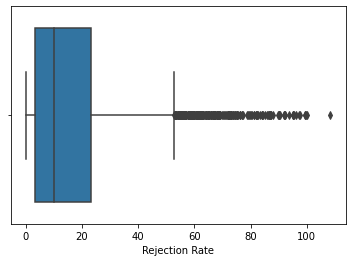

In [75]:
p = sns.boxplot(x='rejection_rate', data=df)
p.set_xlabel('Rejection Rate')
plt.show()

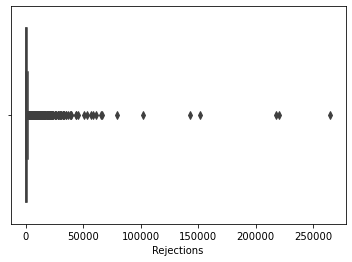

In [76]:
p = sns.boxplot(x='rejected', data=df)
p.set_xlabel('Rejections')
plt.show()

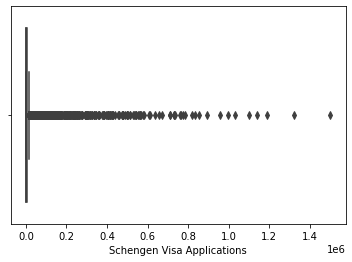

In [77]:
p = sns.boxplot(x='app', data=df)
p.set_xlabel('Schengen Visa Applications')
plt.show()

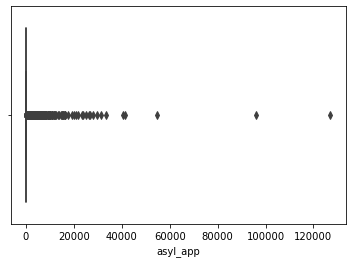

In [79]:
sns.boxplot(x='asyl_app', data=df)
p.set_xlabel('Asylum Applications')
plt.show()

There are lot of outliers in the most relevant variables. Also they are certainly not normally distributed.

I need to remove some of these outliers for a correlation and regression test. To do that, I use the interquartile range method:

In [80]:
for col in ['asyl_app', 'app', 'rejected']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df = df.query(f'({col} >= {Q1 - 1.5 * IQR}) & ({col} <= {Q3 + 1.5 * IQR})')

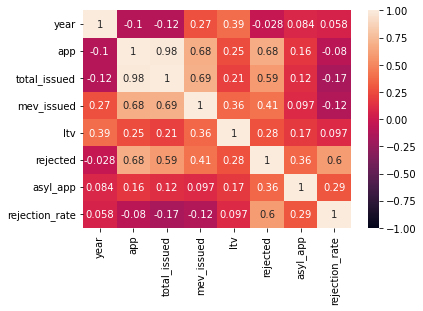

<Figure size 2160x1080 with 0 Axes>

In [86]:
sns.heatmap(df.corr(method='spearman'), vmin=-1, vmax=1, annot=True)
plt.figure(figsize = (30,15))

plt.show()

There appears to be a weak correlation let's see if they are statisctially significant

In [87]:
corr, pval = spearmanr(df['asyl_app'], df['rejection_rate'])

print('Spearman correlation coefficient:', corr)
print('p-value:', pval)

Spearman correlation coefficient: 0.2930352491146371
p-value: 3.3441739215962533e-137


The p-value is way below 0.05 threshold, meaning that the weak correlation between the variables is statistically significant. 

I also want to check if there is causality between them, while also controlling for year, the schengen state, and the application country. 

In [88]:
df = df[['app_country', 'schengen_state', 'asyl_app', 'rejection_rate']]

In [91]:
app_country_dummies = pd.get_dummies(df['app_country'], prefix='app_country', drop_first = True)
schengen_country_dummies = pd.get_dummies(df['schengen_state'], prefix='schengen_state', drop_first = True)

df_with_dummies = pd.concat([df, app_country_dummies, schengen_country_dummies], axis=1)

y = df_with_dummies['rejection_rate']
X = df_with_dummies.drop(columns=['app_country', 'schengen_state', 'rejection_rate'])

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         rejection_rate   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     44.18
Date:                Sat, 01 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:08:08   Log-Likelihood:                -26298.
No. Observations:                6926   AIC:                         5.285e+04
Df Residuals:                    6799   BIC:                         5.372e+04
Df Model:                         126                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


The model has an R-squared value of 0.450, indicating that about 45% of the fluctuations in visa rejection rates can be attributed to the variables in the model. The F-statistic is 44.18, with an extremely low p-value, suggesting that the model is statistically significant and that at least one of the variables has a notable influence on visa rejection rates.

Regarding asylum applications, there's a positive coefficient of 0.0065, implying that an increase in asylum applications might be connected to higher visa rejection rates. However, the p-value for this variable is 0.092, which means it's not statistically significant at a 5% significance level.

# Conclusion

In conclusion, I set set out to explore the relationship between visa rejection rates and asylum applications. The results from the Pearson correlation test suggested a weak yet statistically significant correlation between the two variables, hinting at a potential linear relationship. However, when I dug deeper into the data using the OLS regression model, controlling for additional factors such as the applicant's country and the Schengen state, the relationship between these variables appeared less clear-cut.

The findings from the OLS regression model indicate that, when taking these other factors into account, there is no strong evidence to suggest that the number of asylum applications has a significant effect on the visa rejection rate. This underscores the complexity of the relationship between visa rejection rates and asylum applications and highlights the importance of considering various factors that might influence this relationship.

While my analysis has provided some insights into the dynamics between asylum applications and visa rejection rates, it is clear that further research is needed to better understand the interplay between these variables and the role of other potential factors.